In [1]:
import os 
from pathlib import Path 
import numpy as np 
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt 

In [2]:
# Step 1 - Read X and Y 

In [3]:
# Preparing Required Dictionaries 
# 1 - For Finding Label , label_dict , 
# 2- For Converting String label to number

In [4]:
#1 
label_dict={}
df=pd.read_csv('Dataset/Train/Train.csv')
df.head()
ydata=df.values
#print(ydata.shape)
for i in range(ydata.shape[0]):
    label_dict[ydata[i,0]]=ydata[i,1]
#2
str_num={}
uniq_val=np.unique(ydata[:,1])
#print(uniq_val)
token_id=0
for strnm in uniq_val:
    str_num[strnm]=token_id
    token_id+=1
print(str_num)



{'Bulbasaur': 0, 'Pikachu': 2, 'Charmander': 1}


In [5]:
# Data Analysis 
p=Path('Dataset/Train/Images')
dirs =p.glob('*')
xsize=[]
ysize=[]
for file_path in dirs:
    imgname=str(file_path).split('\\')[-1]
    img=cv.imread(str(file_path))
    # OpenCv reads image in BGR format and matplotlib reads in RGB format =>We need to convert BGR to RGB
    img=cv.cvtColor(img, cv. COLOR_BGR2RGB)
    #print(img.shape)
    xsize.append(img.shape[0])
    ysize.append(img.shape[1])
#print(len(ysize))
#print(len(xsize))
xsize=np.array(xsize)
ysize=np.array(ysize)

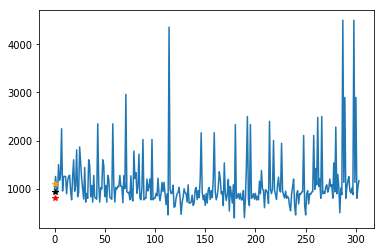

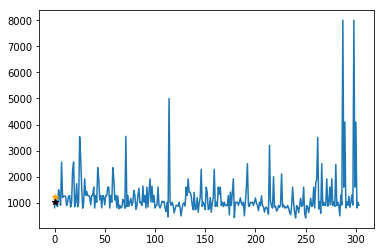

In [6]:
from statistics import mode 
plt.plot(xsize)
plt.plot(mode(xsize),color='red',marker='*')
plt.plot(np.mean(xsize),color='orange',marker='*')
plt.plot(np.median(xsize),color='black',marker='*')
plt.show()

plt.plot(ysize)
plt.plot(mode(ysize),color='red',marker='*')
plt.plot(np.mean(ysize),color='orange',marker='*')
plt.plot(np.median(ysize),color='black',marker='*')
plt.show()

In [7]:
xdimension=int(( np.median(xsize)+np.mean(xsize)+mode(xsize) )/3)
ydimension=int(( np.median(ysize)+np.mean(ysize)+mode(ysize) )/3)
print(xdimension)
print(ydimension)
# Due to memory Constraint of my laptop 
xdimension=int(xdimension/10)
ydimension=int(ydimension/10)
print(xdimension)
print(ydimension)


940
1084
94
108


In [13]:
# X-image_data # y-labels
p=Path('Dataset/Train/Images')
dirs =p.glob('*')
image_data=[]
labels=[]
for file_path in dirs:
    imgname=str(str(file_path).split('\\')[-1])
    #print(type(imgname))
    img=cv.imread(str(file_path))
    # OpenCv reads image in BGR format and matplotlib reads in RGB format =>We need to convert BGR to RGB
    img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
    #print(img.shape)
    # The Size of the image needs to be resized to smaller size 
    img=cv.resize(img,(xdimension,ydimension,))
    image_data.append(img)
    label=label_dict[imgname]
    labels.append(str_num[label])

In [14]:
# Convert List into numpy array 
image_data=np.array(image_data)
labels=np.array(labels)
#print(image_data.shape)

In [15]:
def drawImg(img,show=True):
    plt.imshow(img)
    if (show):
        plt.show()
    return 
#drawImg(image_data[0])

In [16]:
# We need to randomize data so that our algorithm learns it well 
import random 
combined=list(zip(image_data,labels))
random.shuffle(combined)
image_data[:],labels[:]=zip(*combined)

In [17]:
#Flatten The Image 
num_of_sample=image_data.shape[0]
#print(num_of_sample)
image_data=image_data.reshape(num_of_sample,-1)
print(image_data.shape)
print(labels.shape)

(304, 30456)
(304,)


In [18]:
# Creating A Data Dictionary - All Points of a paticular label put together

CLASSES = len(np.unique(labels))

def ClassWiseData(x,y):
    data={}
    for i in range(CLASSES):
        data[i]=[]
    for i in range(x.shape[0]):
        data[ y[i] ].append(x[i])
    for k in data.keys():
        data[k]=np.array(data[k])
    return data

data=ClassWiseData(image_data,labels)

In [19]:
def getDataPairForSVM(d1,d2):
    l1=d1.shape[0]
    l2=d2.shape[0]
    samples=l1+l2
    features=d1.shape[1]
    data_pair=np.zeros((samples,features))
    data_labels=np.zeros((samples,))
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    data_labels[:l1]=-1
    data_labels[l1:]=1
    return data_pair, data_labels

# SVM 

In [20]:
# W=1*n 
# X=m*n 
#where m is the number of training examples and n is the number of features 
class SVM:
    def __init__(self,C=1.0):
        self.b=0 # bias 
        self.W=0 # weights
        self.C=C # penalty 
    def hingeLoss(self,W,X,Y,b):
        # Calculates The Loss
        loss=0.0
        loss+=0.5*np.dot(W,W.T)
        m=X.shape[0]
        for i in range(m):
            ti=Y[i]*(np.dot(W,X[i].T)+b)
            loss+=self.C*max(0,1-ti)
        # loss is a 1*1 sized array so output would be like [[100]] for eg. => Solution loss[0][0]
        return loss[0][0]
    def fit(self,X,Y,batch_size=100,learning_rate=0.001, maxItr=1000):
        no_of_features=X.shape[1]
        no_of_samples=X.shape[0]
        n=learning_rate
        C=self.C
        #Initializing the Model Parameters 
        W=np.zeros((1,no_of_features))
        b=0
        #print(self.hingeLoss(W,X,Y,b))
        losses=[]
        for i in range(maxItr):
            # Training loop 
            l=self.hingeLoss(W,X,Y,b)
            losses.append(l)  
            #print(losses)
            # Batch gradient descent[paper] with random shuffling
            
            ids=np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 Gradient for the batch 
                gradw=0 
                gradb=0
                for j in range(batch_start,batch_start+batch_size):
                    # ids[j] refers to the example id which we are using 
                    if j<no_of_samples:
                        sample_id=ids[j] #just for ease of typing 
                        ti=Y[sample_id]*(np.dot(W,X[sample_id].T)+b)
                        if(ti>=1):
                            gradw+=0 #C*0*Y[i]*X[i]
                            gradb+=0#0+C*0*Y[i]
                        else:
                            gradw+= -C*Y[sample_id]*X[sample_id]
                            gradb+= 0-C*Y[sample_id]
                W=W-n*(W+gradw)
                b=b-n*gradb
            self.W=W
            self.b=b
        return W,b,losses

In [21]:
mySVM=SVM(C=1)

In [22]:
# Now We Need A Function TO Train The nC2 SVMs
# We will store the values of W ,bias (b), loss
def trainSVMS(x,y):
    svm_classifiers={}
    for i in range(CLASSES):
        svm_classifiers[i]={}
        for j in range(i+1,CLASSES):
            d1=data[i]
            d2=data[j]
            xpair,ylabel=getDataPairForSVM(d1,d2)
            wts,b,loss=mySVM.fit(xpair,ylabel,learning_rate=0.000000000001,maxItr=2000)
            #plt.plot(loss)
            #plt.show()
            #return 
            svm_classifiers[i][j]=(wts,b)
    return svm_classifiers
    

In [23]:
svm_classifiers=trainSVMS(image_data,labels)

In [24]:
# Predicting Test Data 
def binaryPredict(x,w,b):
    z=np.dot(x,w.T)+b
    if z>=0:
        return 1
    else:
        return -1
def predict(x):
    # Diferent Classifiers Will Predict Different Output =>We need to find which label is predicted max no. of times
    count=np.zeros((CLASSES,))
    for i in range(CLASSES):
        for j in range(i+1,CLASSES):
            w,b=svm_classifiers[i][j]
            z=binaryPredict(x,w,b)
            if (z==1):
                count[j]+=1
            else:
                count[i]+=1
    final_prediction=np.argmax(count)
    return final_prediction

In [25]:
def accuracy(x,y):
    count=0
    for i in range(x.shape[0]):
        predictions=predict(x[i])
        if(predictions==y[i]):
            count+=1
    return count/x.shape[0]


In [26]:
accuracy(image_data,labels)

0.6546052631578947

In [30]:
df=pd.read_csv('Dataset/Test/test.csv')
Xtest=df.values

test_img_data=[]
#print(type(test_img_data))
testp=Path('Dataset/Train/Images')
testdirs=testp.glob('*')
for file_path in testdirs:
    imgname=str(file_path).split('\\')[-1]
    img=cv.imread(str(file_path))
    # OpenCv reads image in BGR format and matplotlib reads in RGB format =>We need to convert BGR to RGB
    img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
    #print(img.shape)
    # The Size of the image needs to be resized to smaller size 
    img=cv.resize(img,(xdimension,ydimension))
    test_img_data.append(img)

In [31]:
df=pd.read_csv('Dataset/Test/test.csv')
Xtest=df.values
#print(Xtest)
test_img_data={}

testp=Path('Dataset/Test/Images')
testdirs=testp.glob('*')

for img_file in testdirs:
    imgname=str(img_file).split('\\')[-1]
    img=cv.imread(str(img_file))
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img=cv.resize(img,(xdimension,ydimension,))
    img=img.reshape(-1,)
    test_img_data[str(imgname)]=img
#print(test_img_data.keys())  

In [32]:
ytest=[]
for fname in Xtest:
    #print(fname[0])
    img_data=test_img_data[fname[0]]
    ans=predict(img_data)
    ytest.append(ans)

In [41]:
# Num to string 
num_str={}
for i in str_num.keys():
    num_str[str_num[i]]=i
ans_to_save=[]
for i in range(Xtest.shape[0]):
    #print(Xtest[i][0])
    res=[]
    res.append(Xtest[i][0])
    res.append(num_str[ ytest[i] ])
    ans_to_save.append(res)

In [42]:
#ans_to_save=np.array(ans_to_save)
print(ans_to_save[0][0])

1106.jpg


In [53]:
dfinal = pd.DataFrame(ans_to_save)
hname=['ImageId','NameOfPokemon']
dfinal.to_csv('yprediction.csv',header=['ImageId','NameOfPokemon'],index=False)
dfinal.head()
dfinal.to_csv?

In [54]:
dfinal.head()

,0,1
0,1106.jpg,Bulbasaur
1,2236.jpg,Charmander
2,1131.jpg,Bulbasaur
3,2221.jpg,Charmander
4,2011.jpg,Charmander
